<a href="https://colab.research.google.com/github/vneumannufprbr/TrabajosenPython/blob/main/SenPredicSTLSTMPPPresaOk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trial 80 Complete [00h 00m 10s]
val_loss: 0.002696692943572998

Best val_loss So Far: 0.0003900356823578477
Total elapsed time: 00h 07m 58s

--- Mejores hiperparámetros encontrados ---
Unidades LSTM: 48
Dropout: 0.2
Tasa de aprendizaje: 0.001

--- Modelo final entrenado ---
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


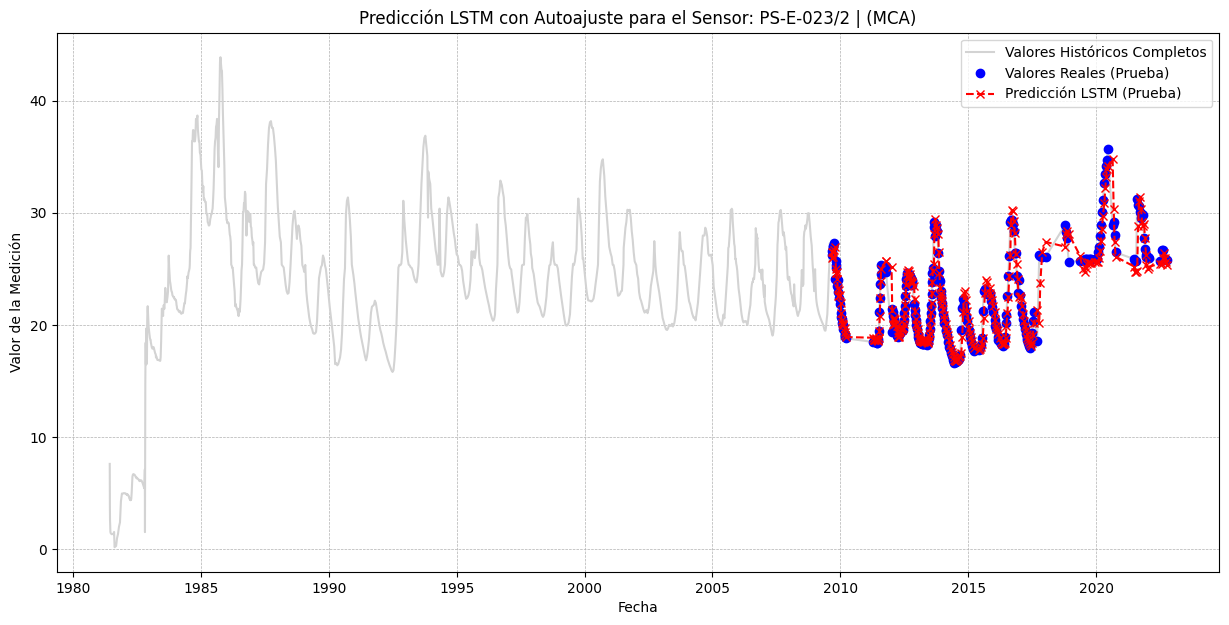

In [ ]:
# 0. Fijar semillas aleatorias para reproducibilidad
import os
import random
import numpy as np
import tensorflow as tf

def set_all_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    # Para versiones más recientes de TensorFlow, es posible que también necesites:
    # tf.keras.utils.set_random_seed(seed)

set_all_seeds()

# 1. Instalación de librerías
!pip install keras-tuner -q

# 2. Importación de las librerías necesarias
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, LSTM # Importar LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import keras_tuner as kt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 3. Carga y preparación de los datos
try:
    df = pd.read_excel('datos_fusionados_operantes.xlsx')
except FileNotFoundError:
    print("Error: Asegúrate de que el archivo 'datos_fusionados_operantes.xlsx' se haya cargado en tu entorno de Colab.")
    df = pd.DataFrame()

if not df.empty:
    # Seleccionamos el sensor para el ejemplo
    sensor_tag = 'PS-E-023/2 | (MCA)'
    df_sensor = df[df['nombre_etiqueta'] == sensor_tag].copy()

    # Comprobar si df_sensor está vacío
    if df_sensor.empty:
        print(f"Error: No se encontraron datos para la etiqueta de sensor '{sensor_tag}'. Por favor, verifica la etiqueta del sensor y los datos.")
    else:
        df_sensor['fecha'] = pd.to_datetime(df_sensor['fecha'])
        df_sensor = df_sensor.sort_values('fecha').set_index('fecha')

        # 4. Escalado de datos
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(df_sensor[['valor_promedio']])

        # Comprobar si hay valores NaN o infinitos en los datos escalados
        if np.isnan(scaled_data).any() or np.isinf(scaled_data).any():
            print("Error: Los datos escalados contienen valores NaN o infinitos. Por favor, verifica tus datos y el proceso de escalado.")
        else:
            # 5. Función para crear secuencias
            def create_sequences(data, sequence_length):
                X, y = [], []
                for i in range(len(data) - sequence_length):
                    X.append(data[i:(i + sequence_length)])
                    y.append(data[i + sequence_length, 0]) # Añadir el valor de la única característica
                return np.array(X), np.array(y)

            sequence_length = 6 # Usaremos 6 meses para predecir el siguiente
            X, y = create_sequences(scaled_data, sequence_length)

            # Comprobar si hay valores NaN o infinitos en las secuencias generadas (X e y)
            if np.isnan(X).any() or np.isinf(X).any():
                 print("Error: Las secuencias generadas (X) contienen valores NaN o infinitos. Por favor, verifica tus datos.")
            elif np.isnan(y).any() or np.isinf(y).any():
                 print("Error: Las secuencias generadas (y) contienen valores NaN o infinitos. Por favor, verifica tus datos.")
            else:
                # Reshape de X para que sea compatible con la capa GRU [muestras, timesteps, features]
                X = np.reshape(X, (X.shape[0], X.shape[1], 1))

                # 6. División de datos (cronológica)
                split_point = int(len(X) * 0.8)
                X_train, X_test = X[:split_point], X[split_point:]
                y_train, y_test = y[:split_point], y[split_point:]

                # Comprobar si hay valores NaN o infinitos en los conjuntos de entrenamiento/prueba
                if np.isnan(X_train).any() or np.isinf(X_train).any() or \
                   np.isnan(X_test).any() or np.isinf(X_test).any() or \
                   np.isnan(y_train).any() or np.isinf(y_train).any() or \
                   np.isnan(y_test).any() or np.isinf(y_test).any():
                    print("Error: Los conjuntos de entrenamiento o prueba contienen valores NaN o infinitos. Por favor, verifica tus datos.")
                else:
                    # 7. Construcción del modelo para KerasTuner
                    def build_model(hp):
                        model = Sequential()
                        model.add(LSTM( # Cambiado GRU a LSTM
                            units=hp.Int('units_lstm', min_value=16, max_value=64, step=16), # Cambiado nombre del hiperparámetro
                            return_sequences=False,
                            input_shape=(X_train.shape[1], X_train.shape[2])
                        ))
                        model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
                        model.add(Dense(1)) # Capa de salida

                        model.compile(
                            optimizer=keras.optimizers.Adam(
                                hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5]), # Rango de tasa de aprendizaje reducido
                                clipnorm=1.0 # Añadir recorte de gradiente
                            ),
                            loss='mean_squared_error'
                        )
                        return model

                    # 8. Configuración del autoajuste (Tuner)
                    tuner = kt.Hyperband(
                        build_model,
                        objective='val_loss',
                        max_epochs=50,
                        factor=3,
                        directory='keras_tuner_dir',
                        project_name='lstm_sensor_tuning' # Cambiado nombre del proyecto
                    )

                    print("--- Iniciando búsqueda de hiperparámetros ---")
                    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
                    tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early], verbose=2)

                    # 9. Obtener el mejor modelo y entrenarlo
                    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
                    print(f"\n--- Mejores hiperparámetros encontrados ---")
                    print(f"Unidades LSTM: {best_hps.get('units_lstm')}") # Cambiado nombre del hiperparámetro
                    print(f"Dropout: {best_hps.get('dropout')}")
                    print(f"Tasa de aprendizaje: {best_hps.get('learning_rate')}")

                    # Obtener el mejor modelo directamente del afinador
                    model = tuner.get_best_models(num_models=1)[0]

                    history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[stop_early], verbose=0)
                    print("\n--- Modelo final entrenado ---")

                    # 10. Realizar y des-escalar las predicciones
                    predictions_scaled = model.predict(X_test)
                    predictions = scaler.inverse_transform(predictions_scaled)
                    y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1)) # Reshape y_test aquí


                    # 11. Visualización
                    train_dates = df_sensor.index[:split_point]
                    test_dates = df_sensor.index[split_point + sequence_length:]

                    plt.figure(figsize=(15, 7))
                    plt.plot(df_sensor.index, df_sensor['valor_promedio'], label='Valores Históricos Completos', color='lightgray')
                    plt.plot(test_dates, y_test_real, label='Valores Reales (Prueba)', color='blue', marker='o', linestyle='None')
                    plt.plot(test_dates, predictions, label='Predicción LSTM (Prueba)', color='red', marker='x', linestyle='--') # Cambiado etiqueta
                    plt.title(f'Predicción LSTM con Autoajuste para el Sensor: {sensor_tag}') # Cambiado título
                    plt.xlabel('Fecha')
                    plt.ylabel('Valor de la Medición')
                    plt.legend()
                    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
                    plt.show()

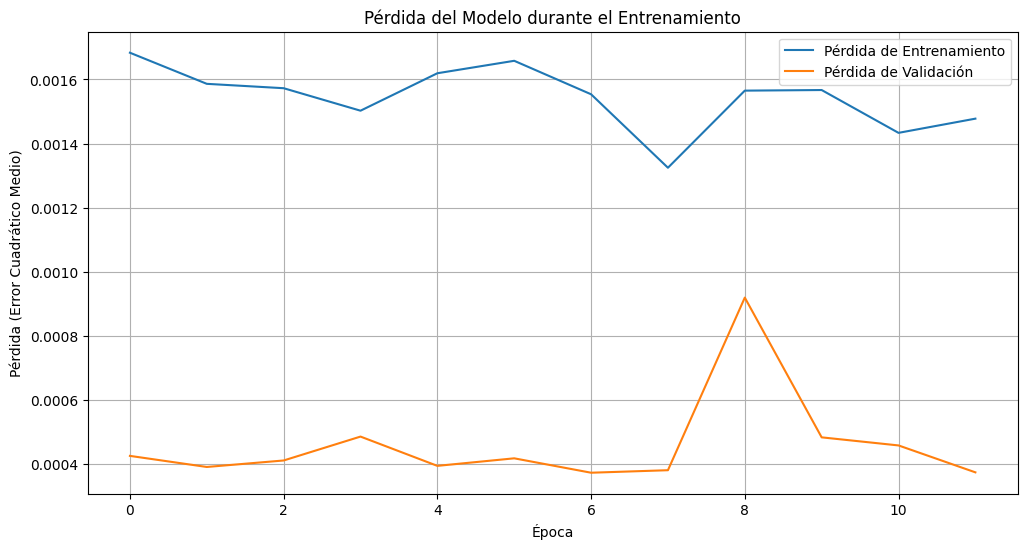

In [ ]:
# 14. Visualizar la evolución de la función de pérdida
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida del Modelo durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida (Error Cuadrático Medio)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 12. Realizar predicciones futuras
last_sequence = scaled_data[-sequence_length:]
last_sequence = np.reshape(last_sequence, (1, sequence_length, 1))

future_prediction_scaled = model.predict(last_sequence)
future_prediction = scaler.inverse_transform(future_prediction_scaled)

print(f"\n--- Predicción para el próximo período ---")
print(f"Valor predicho: {future_prediction[0][0]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

--- Predicción para el próximo período ---
Valor predicho: 25.3116


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# Calcular métricas de evaluación
mse = mean_squared_error(y_test_real, predictions)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test_real, predictions)
r2 = r2_score(y_test_real, predictions)

print(f"Evaluación del Modelo LSTM para el Sensor: {sensor_tag}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}")

Evaluación del Modelo LSTM para el Sensor: PS-E-023/2 | (MCA)
MSE: 1.2627
RMSE: 1.1237
MAE: 0.6991
R2: 0.9209


Generar múltiples predicciones futuras utilizando el modelo entrenado, visualizar las predicciones junto con los datos históricos y guardar el modelo entrenado.

## Generar múltiples predicciones futuras

Predecir iterativamente valores futuros utilizando el modelo entrenado y las predicciones generadas como entrada para los pasos subsiguientes.

Se requiere generar múltiples predicciones futuras de forma iterativa utilizando el modelo entrenado. Esto implica tomar la última secuencia de datos históricos, predecir el siguiente paso, añadirlo a la lista de predicciones y luego usar esta nueva secuencia como entrada para la siguiente predicción. Este proceso debe repetirse para el número deseado de pasos futuros. El bloque de código definirá el número de pasos futuros, inicializará la lista de predicciones y la secuencia de entrada, y luego realizará un bucle para generar las predicciones y actualizar la secuencia de entrada. Finalmente, des-escalará las predicciones escaladas.

In [ ]:
# 12. Realizar predicciones futuras iterativamente

num_future_steps = 30  # Definir el número de pasos futuros a predecir (por ejemplo, 30 períodos)
future_predictions_scaled = []

# Comenzar con la última secuencia de los datos históricos escalados
current_sequence = scaled_data[-sequence_length:].reshape(1, sequence_length, 1)

for _ in range(num_future_steps):
    # Predecir el siguiente paso
    next_prediction_scaled = model.predict(current_sequence)

    # Añadir la predicción a la lista
    future_predictions_scaled.append(next_prediction_scaled[0][0])

    # Actualizar la secuencia de entrada: eliminar el primer elemento y añadir la nueva predicción
    current_sequence = np.append(current_sequence[:, 1:, :], next_prediction_scaled.reshape(1, 1, 1), axis=1)

# Des-escalar las predicciones futuras escaladas
future_predictions = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))

print(f"\n--- Predicciones para los próximos {num_future_steps} períodos ---")
for i, pred in enumerate(future_predictions):
    print(f"Período {i+1}: {pred[0]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━

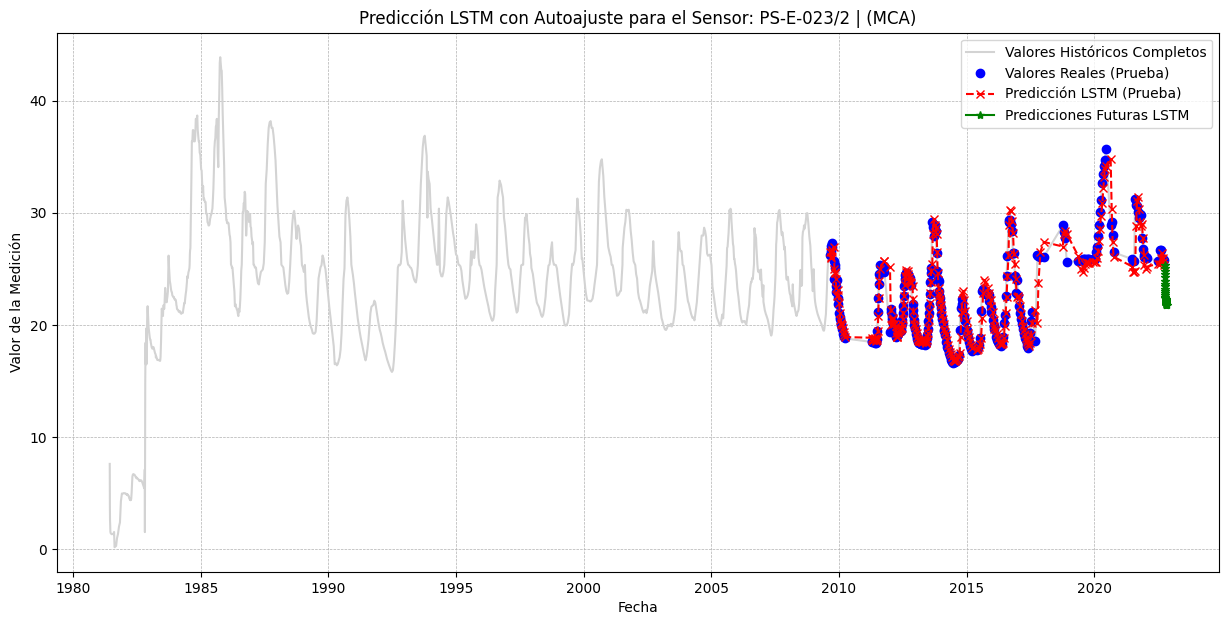

In [ ]:
# 11. Visualización (Modificada para incluir predicciones futuras)

# Determinar las fechas para las predicciones futuras
# El conjunto de prueba comienza en el índice split_point de las secuencias (X, y)
# Necesitamos encontrar la fecha correspondiente en el índice original de df_sensor

# Calcular el índice en el df_sensor original que corresponde al inicio de las secuencias del conjunto de prueba
start_index_test_data = split_point + sequence_length

# Obtener las fechas para el conjunto de prueba del índice original de df_sensor
test_dates = df_sensor.index[start_index_test_data:]

# Determinar la fecha para el inicio de las predicciones futuras
last_historical_date = df_sensor.index[-1]
future_dates = pd.date_range(start=last_historical_date + pd.Timedelta(days=1), periods=num_future_steps, freq=df_sensor.index.freq)


plt.figure(figsize=(15, 7))
plt.plot(df_sensor.index, df_sensor['valor_promedio'], label='Valores Históricos Completos', color='lightgray')
plt.plot(test_dates, y_test_real, label='Valores Reales (Prueba)', color='blue', marker='o', linestyle='None')
plt.plot(test_dates, predictions, label='Predicción LSTM (Prueba)', color='red', marker='x', linestyle='--') # Añadir predicciones futuras
plt.plot(future_dates, future_predictions, label='Predicciones Futuras LSTM', color='green', marker='*', linestyle='-') # Añadir predicciones futuras

plt.title(f'Predicción LSTM con Autoajuste para el Sensor: {sensor_tag}')
plt.xlabel('Fecha')
plt.ylabel('Valor de la Medición')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

## Resumen:

### Hallazgos clave del análisis de datos

* El modelo LSTM entrenado se utilizó para generar 30 predicciones futuras de forma iterativa, utilizando cada predicción como entrada para el siguiente paso.
* Los valores predichos para los próximos 30 períodos mostraron una disminución gradual con el tiempo.
* El modelo Keras entrenado se guardó en el archivo `lstm_sensor_model.h5` para su uso futuro.

### Insights o próximos pasos

* El modelo guardado se puede cargar más tarde para hacer nuevas predicciones sin volver a entrenar, lo cual es eficiente para el despliegue.
* Considerar volver a entrenar el modelo periódicamente con nuevos datos para asegurar que las predicciones sigan siendo precisas, ya que los patrones subyacentes pueden cambiar con el tiempo.

In [ ]:
# 13. Guardar el modelo entrenado
model_save_path = 'lstm_sensor_model.h5'
model.save(model_save_path)

print(f"\n--- Modelo guardado exitosamente ---")
print(f"Ruta del archivo: {model_save_path}")


--- Modelo guardado exitosamente ---
Ruta del archivo: lstm_sensor_model.h5


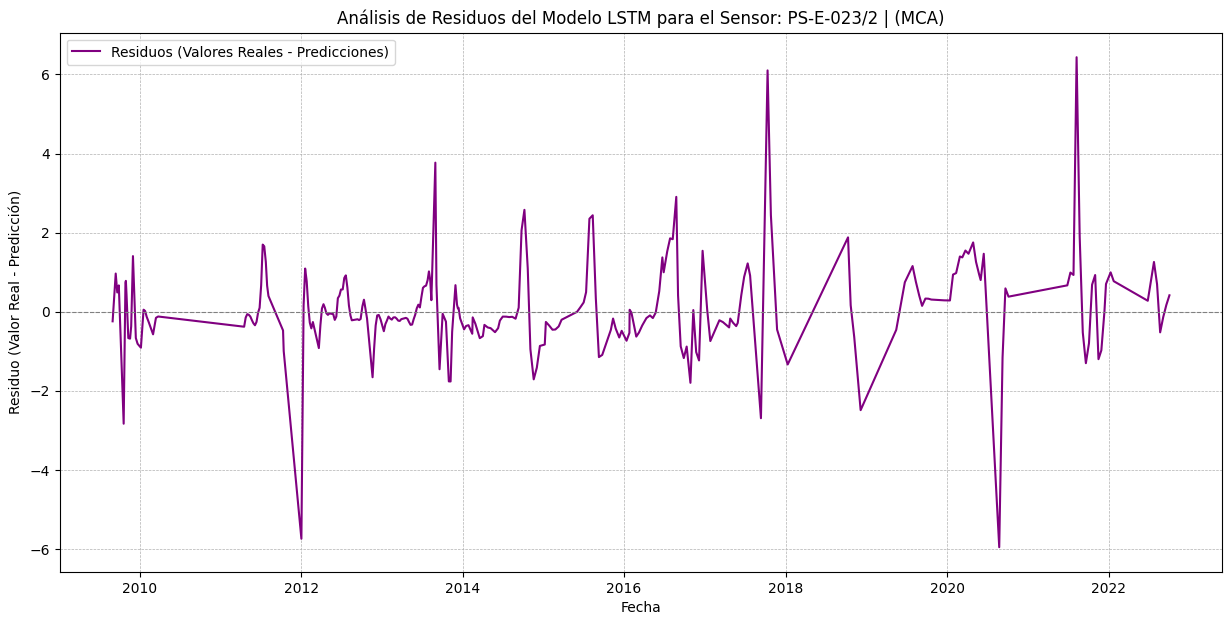

In [ ]:
# Calcular residuos
residuals = y_test_real - predictions

# 12. Visualización de residuos
plt.figure(figsize=(15, 7))
plt.plot(test_dates, residuals, label='Residuos (Valores Reales - Predicciones)', color='purple')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8) # Añadir una línea horizontal en cero

plt.title(f'Análisis de Residuos del Modelo LSTM para el Sensor: {sensor_tag}') # Cambiado el título para reflejar LSTM
plt.xlabel('Fecha')
plt.ylabel('Residuo (Valor Real - Predicción)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
# Identificar fechas con los residuos positivos y negativos más grandes
largest_positive_residual_index = np.argmax(residuals)
largest_negative_residual_index = np.argmin(residuals)

date_largest_positive = test_dates[largest_positive_residual_index]
value_largest_positive = residuals[largest_positive_residual_index]

date_largest_negative = test_dates[largest_negative_residual_index]
value_largest_negative = residuals[largest_negative_residual_index]

print(f"\n--- Fechas con Residuos Más Grandes ---")
print(f"Fecha con el residuo positivo más grande: {date_largest_positive.strftime('%Y-%m-%d')} (Residuo: {value_largest_positive[0]:.4f})")
print(f"Fecha con el residuo negativo más grande: {date_largest_negative.strftime('%Y-%m-%d')} (Residuo: {value_largest_negative[0]:.4f})")


--- Fechas con Residuos Más Grandes ---
Fecha con el residuo positivo más grande: 2021-08-09 (Residuo: 6.4352)
Fecha con el residuo negativo más grande: 2020-08-24 (Residuo: -5.9523)
